In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random
import math
from tqdm import tqdm

from DynamicalSystemLayer import *
from VaeNeuralODELayer import *

# Data generation

In [103]:
p = torch.Tensor([[0., 1., -0.05, 0]])
z0 = torch.Tensor([[0., 1.]])

times = torch.from_numpy(np.arange(0,200))

ode_true = VaeNeuralODE(LinearODEF(p))
obs = ode_true(z0, times, return_whole_sequence=True).detach()
obs = obs.squeeze(1)

In [104]:
obs.shape

torch.Size([200, 2])

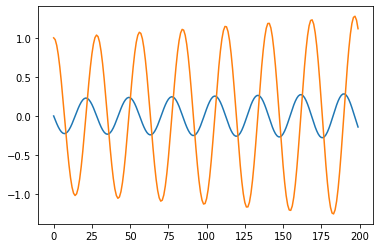

In [106]:
plt.plot(obs[:,0].detach().numpy())
plt.plot(obs[:,1].detach().numpy())
plt.show()

In [96]:
pend_data = obs
window_len = 5
window_set = pend_data.view(40, 5, 2)
times_set = times.view(40, 5)

In [95]:
x = torch.randn(200,2)
y = x.view(40, 5, 2)
y[0,0]

tensor([ 0.2651, -1.1379])

In [97]:
window_set.shape

torch.Size([40, 5, 2])

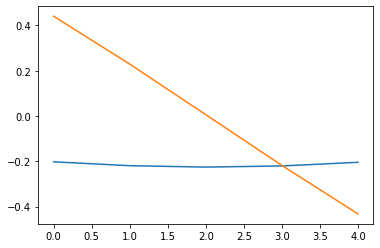

In [100]:
plt.plot(window_set[1,:,0].detach().numpy())
plt.plot(window_set[1,:,1].detach().numpy())
plt.show()

# Model

In [211]:
class LinearODEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x0, t, A):
        time_len = t.size(0)
        x_dim = x0.size(0) #x_dim = 1
        z = torch.zeros(time_len, 2)
        z0 = x0
        

        for it in range(time_len-1):
            h = t[it+1] - t[it]
            z0 = z0 + h*z0.matmul(A)
            z[it+1] = z0
        ctx.save_for_backward(A, z.clone(), t)  
        return z
    
    @staticmethod
    def backward(ctx, grad_out):
        A, z, t  = ctx.saved_tensors
        time_len = t.size(0)
        z_dim = z.size(1)
        n_param = A.view(-1).shape[0]
        grad_in = grad_out.clone()
        
        
        adzdA = torch.zeros(time_len, grad_in.shape[1], z_dim)
        
        for it in range(time_len-1, 0, -1):
            zi = z[it].view(1, z_dim)
            ti = t[it]
            ai = grad_in[it].view(1, grad_in.shape[1])
            
            h = ti - t[it-1]
            u = h*ai.t().matmul(zi)
            adzdA[it] = u
            
        return adzdA, None, None
         

In [213]:
#for later
class LinearODELayer(nn.Module):
    def __init__(self, data_dim):
        super(LinearODELayer, self).__init__()
        self.data_dim = data_dim
        self.A = nn.Parameter(torch.Tensor(self.data_dim, self.data_dim))
        
    def forward(self, z0, t):
        #z0 = torch.Tensor([x[0], x[1]])
        z = LinearODEFunction.apply(z0, t, self.A)
        return z

# Training

In [190]:
dtype = torch.float
device = torch.device("cpu")

p = torch.Tensor([[0., 1., -0.05, 0]])
z0 = torch.Tensor([[0., 1.]])

times = torch.from_numpy(np.arange(0,200))

ode_true = VaeNeuralODE(LinearODEF(p))
obs = ode_true(z0, times, return_whole_sequence=True).detach()
obs = obs.squeeze(1)
obs = obs.detach().requires_grad_(True)

pend_data = obs
window_len = 5
window_set = pend_data.view(40, 5, 2)
times_set = times.view(40, 5)



test_set = window_set[30:, :, :]
train_set = window_set[:30,:]

test_time = times_set[30:]
train_time = times_set[:30]

train_sample = train_set.shape[1]
test_sample = test_set.shape[1]

A = torch.randn(2,2, device=device, dtype=dtype, requires_grad=True)

In [86]:
learning_rate = 0.1

In [114]:
x = torch.randn(10, 2)
w1 = torch.randn(2, 2, requires_grad=True)
w2 = torch.randn(2, 2, requires_grad=True)
y = (x.mm(w1)).mm(w2)
loss = (y - x).pow(2).sum()
print(loss.grad)
print(w1)
print(w2)

None
tensor([[-0.6514, -0.5973],
        [ 0.5740,  0.4579]], requires_grad=True)
tensor([[ 0.9613,  0.9761],
        [ 0.4916, -0.3768]], requires_grad=True)


In [115]:
loss.backward()
print(loss.grad)
print(w1.grad)
print(w2.grad)

None
tensor([[-41.1018, -13.8767],
        [ -0.9375,   4.5926]])
tensor([[25.2723,  1.9894],
        [22.8386,  2.2206]])


In [116]:
with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad
        
        w1.grad.zero_()
        w2.grad.zero_()
        
        print(w1)
        print(w2)

tensor([[ 3.4588e+00,  7.9035e-01],
        [ 6.6771e-01, -1.4053e-03]], requires_grad=True)
tensor([[-1.5660,  0.7772],
        [-1.7922, -0.5988]], requires_grad=True)


Hello
start training
epoch: 1
train_loss: 220.28897070884705
test_loss: 360.58888149261475
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)


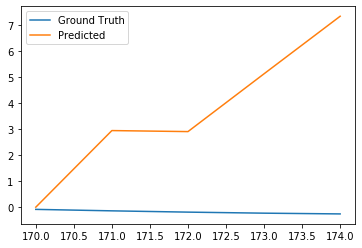

epoch: 2
train_loss: 440.5779414176941
test_loss: 721.1777629852295
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 3
train_loss: 660.8669121265411
test_loss: 1081.7666444778442
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 4
train_loss: 881.1558828353882
test_loss: 1442.355525970459
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 5
train_loss: 1101.4448535442352
test_loss: 1802.9444074630737
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 6
train_loss: 1321.7338242530823
test_loss: 2163.5332889556885
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 7
train_loss: 1542.0227949619293
test_loss: 2524.122170448303
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 8
train_loss: 1762.3117656707764
test_l

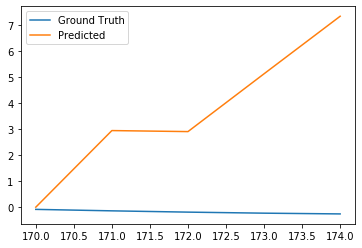

epoch: 12
train_loss: 2643.4676485061646
test_loss: 4327.066577911377
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 13
train_loss: 2863.7566192150116
test_loss: 4687.655459403992
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 14
train_loss: 3084.0455899238586
test_loss: 5048.244340896606
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 15
train_loss: 3304.3345606327057
test_loss: 5408.833222389221
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 16
train_loss: 3524.6235313415527
test_loss: 5769.422103881836
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 17
train_loss: 3744.9125020504
test_loss: 6130.010985374451
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 18
train_loss: 3965.201472759247
tes

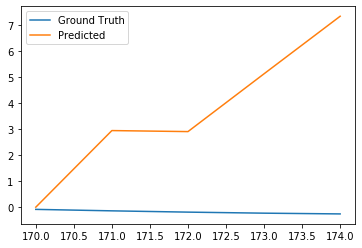

epoch: 22
train_loss: 4846.357355594635
test_loss: 7932.955392837524
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 23
train_loss: 5066.646326303482
test_loss: 8293.54427433014
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 24
train_loss: 5286.935297012329
test_loss: 8654.133155822754
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 25
train_loss: 5507.224267721176
test_loss: 9014.722037315369
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 26
train_loss: 5727.513238430023
test_loss: 9375.310918807983
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 27
train_loss: 5947.80220913887
test_loss: 9735.899800300598
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 28
train_loss: 6168.091179847717
test_los

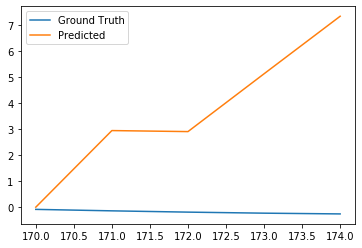

epoch: 32
train_loss: 7049.2470626831055
test_loss: 11538.844207763672
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 33
train_loss: 7269.5360333919525
test_loss: 11899.433089256287
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 34
train_loss: 7489.8250041008
test_loss: 12260.021970748901
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 35
train_loss: 7710.113974809647
test_loss: 12620.610852241516
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 36
train_loss: 7930.402945518494
test_loss: 12981.19973373413
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 37
train_loss: 8150.691916227341
test_loss: 13341.788615226746
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 38
train_loss: 8370.980886936188
t

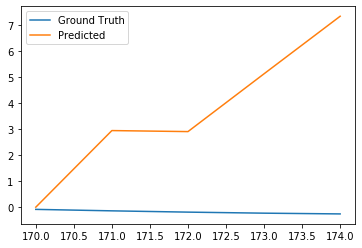

epoch: 42
train_loss: 9252.136769771576
test_loss: 15144.73302268982
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 43
train_loss: 9472.425740480423
test_loss: 15505.321904182434
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 44
train_loss: 9692.71471118927
test_loss: 15865.910785675049
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 45
train_loss: 9913.003681898117
test_loss: 16226.499667167664
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 46
train_loss: 10133.292652606964
test_loss: 16587.08854866028
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 47
train_loss: 10353.581623315811
test_loss: 16947.677430152893
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 48
train_loss: 10573.870594024658


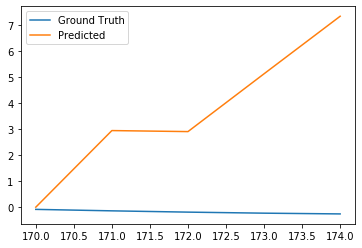

epoch: 52
train_loss: 11455.026476860046
test_loss: 18750.621837615967
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 53
train_loss: 11675.315447568893
test_loss: 19111.21071910858
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 54
train_loss: 11895.60441827774
test_loss: 19471.799600601196
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 55
train_loss: 12115.893388986588
test_loss: 19832.38848209381
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 56
train_loss: 12336.182359695435
test_loss: 20192.977363586426
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 57
train_loss: 12556.471330404282
test_loss: 20553.56624507904
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 58
train_loss: 12776.7603011131

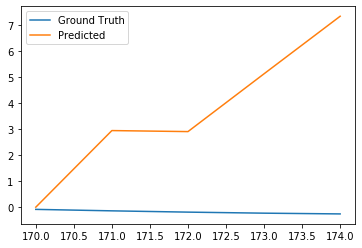

epoch: 62
train_loss: 13657.916183948517
test_loss: 22356.510652542114
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 63
train_loss: 13878.205154657364
test_loss: 22717.09953403473
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 64
train_loss: 14098.494125366211
test_loss: 23077.688415527344
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 65
train_loss: 14318.783096075058
test_loss: 23438.27729701996
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 66
train_loss: 14539.072066783905
test_loss: 23798.866178512573
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 67
train_loss: 14759.361037492752
test_loss: 24159.455060005188
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 68
train_loss: 14979.65000820

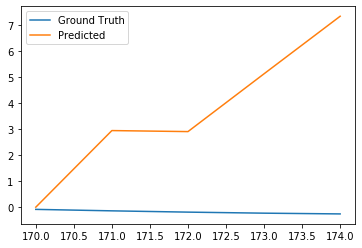

epoch: 72
train_loss: 15860.805891036987
test_loss: 25962.39946746826
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 73
train_loss: 16081.094861745834
test_loss: 26322.988348960876
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 74
train_loss: 16301.383832454681
test_loss: 26683.57723045349
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 75
train_loss: 16521.67280316353
test_loss: 27044.166111946106
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 76
train_loss: 16741.961773872375
test_loss: 27404.75499343872
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 77
train_loss: 16962.250744581223
test_loss: 27765.343874931335
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 78
train_loss: 17182.5397152900

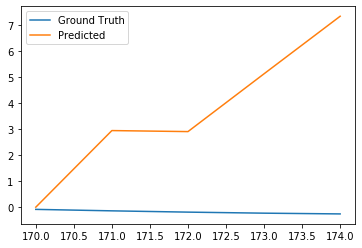

epoch: 82
train_loss: 18063.695598125458
test_loss: 29568.28828239441
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 83
train_loss: 18283.984568834305
test_loss: 29928.877163887024
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 84
train_loss: 18504.273539543152
test_loss: 30289.46604537964
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 85
train_loss: 18724.562510252
test_loss: 30650.054926872253
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 86
train_loss: 18944.851480960846
test_loss: 31010.643808364868
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 87
train_loss: 19165.140451669693
test_loss: 31371.232689857483
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 88
train_loss: 19385.42942237854

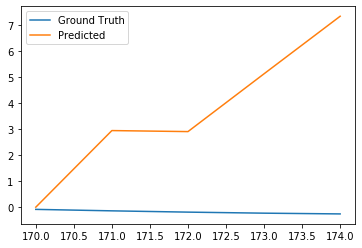

epoch: 92
train_loss: 20266.58530521393
test_loss: 33174.17709732056
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 93
train_loss: 20486.874275922775
test_loss: 33534.76597881317
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 94
train_loss: 20707.163246631622
test_loss: 33895.354860305786
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 95
train_loss: 20927.45221734047
test_loss: 34255.9437417984
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 96
train_loss: 21147.741188049316
test_loss: 34616.532623291016
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 97
train_loss: 21368.030158758163
test_loss: 34977.12150478363
predicted A:
tensor([[ 0.1525,  0.2243],
        [ 2.5875, -1.1442]], requires_grad=True)
epoch: 98
train_loss: 21588.31912946701
t

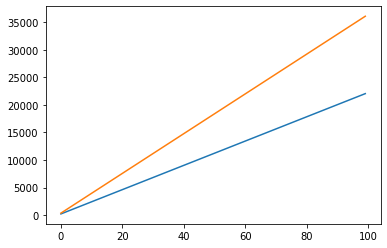

In [212]:
print('Hello')
learning_rate = 0.1
train_loss = 0
test_loss = 0
train_loss_store = []
test_loss_store = []

print('start training')
for epoch in range(100):
    ode = LinearODEFunction.apply
    
    for n in range(train_sample):
        ytrain = train_set[n,:,:]
        z0 = torch.Tensor([ytrain[0,0], ytrain[0, 1]])
        t = train_time[n,:]
        z = ode(z0, t, A)
        ztrain = z
        
        loss = (ztrain - ytrain).pow(2).sum()
        train_loss += loss.item()
        loss.backward()
        
        with torch.no_grad():
            A -= learning_rate*A.grad
            A.grad.zero_()
            
    for n in range(test_sample):
        with torch.no_grad():
            ytest = test_set[n,:,:]
            z0 = torch.Tensor([ytest[0,0], ytest[0,1]])
            t = test_time[n,:]
            z = ode(z0, t, A)
            ztest = z
            
            loss = (ztest - ytest).pow(2).sum()
            test_loss += loss.item()
            
    train_loss_store.append(train_loss)
    test_loss_store.append(test_loss)
    print('epoch:', epoch+1)
    print('train_loss:', train_loss)
    print('test_loss:', test_loss)
    print('predicted A:')
    print(A)
    if epoch%10 == 0:
        plt.plot(t.numpy(), ytest[:,0].detach().numpy(), label='Ground Truth')
        plt.plot(t.numpy(), ztest[:,0].detach().numpy(), label='Predicted');
        plt.legend()
        plt.show()
print('...training complete')        
plt.plot(train_loss_store, label='training loss')
plt.plot(test_loss_store, label='test loss')
plt.show()
    

In [177]:
A

tensor([[ 0.0321, -0.0059],
        [ 0.0682,  0.0345]], requires_grad=True)